         network: 
         station: 
        location: 
         channel: 
       starttime: 2015-12-08T14:27:57.000000Z
         endtime: 2015-12-08T14:27:59.999000Z
   sampling_rate: 1000.0
           delta: 0.001
            npts: 3000
           calib: 0.00016985
         _format: SEG2
            seg2: AttribDict({'FIXED_GAIN': u'24 DB', 'ACQUISITION_TIME': u'14:27:57', 'SHOT_SEQUENCE_NUMBER': u'1635', 'TRACE_SORT': u'AS_ACQUIRED', 'DELAY': u'0.000', 'CHANNEL_NUMBER': u'320', 'AMPLITUDE_RECOVERY': u'NONE', 'RECEIVER_STATION_NUMBER': u'1', 'DIGITAL_HIGH_CUT_FILTER': u'0 0', 'COMPANY': u'Geometrics', 'ACQUISITION_DATE': u'08/Dec/2015', 'DESCALING_FACTOR': u'1.698500E-004', 'SOURCE': u'ACCELERATED_WEIGHT_DROP VERTICAL', 'ALIAS_FILTER': u'416.66 0', 'SOURCE_LINE_NUMBER': u'8', 'SAMPLE_INTERVAL': u'0.001', 'JOB_ID': u'0000', 'OBSERVER': u'Observer', 'SOURCE_LOCATION': u'749714.96 3704819.88 0.00', 'RECEIVER_LOCATION': u'749718.77 3704820.89 0.00', 'LINE_ID': u'0', 'RAW_RECORD': u'D:\\

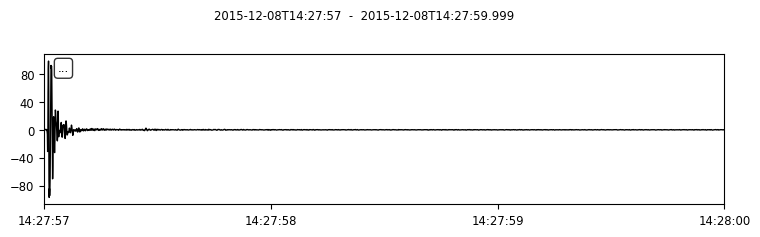

In [2]:
%matplotlib inline
from obspy import read, UTCDateTime
import matplotlib.pyplot as plt
# RAW data
all_traces = read('01.dat') # Raw SEG2 trace
trace=all_traces[4] # select first geophone 
print(trace.stats)
trace.plot()

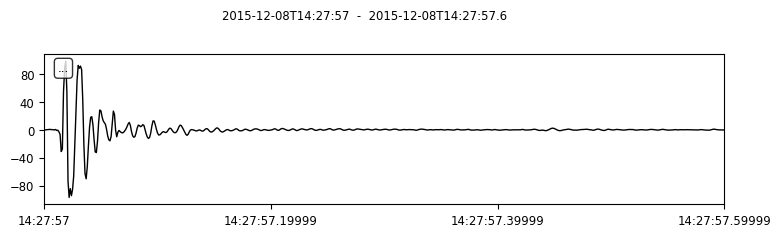

In [3]:
# Cut length of trace to match simulation
stime = trace.stats.starttime
beginTime = UTCDateTime(stime)
trace.trim(beginTime, beginTime+0.6)
trace.plot()

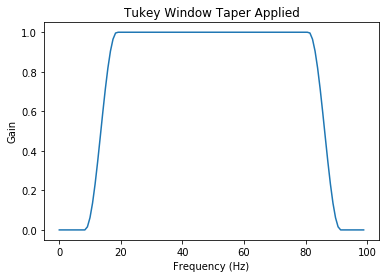

In [54]:
import numpy as np
from scipy import signal
from obspy.signal.util import _npts2nfft
from obspy.signal.invsim import cosine_sac_taper
from scipy.fftpack import fft, ifft, fftfreq

# Setup prefilter with cosine taper
npts = len(trace.data)
nfft = _npts2nfft(npts)
freq_pos = signal.tukey(101, alpha=0.25)
freq_pos = np.pad(freq_pos, 10,'constant',constant_values=0)
freq_pos.resize(nfft/2)
freq_neg = freq_pos[::-1]
freq_taper = np.append(freq_pos, freq_neg)
freq_pos = np.pad(freq_pos, 10,'constant',constant_values=0)
# Plot the filter
freqs = fftfreq(nfft, d=0.001)
plt.plot(freqs[0:120],freq_taper[0:120])
plt.title('Tukey Window Taper Applied')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')

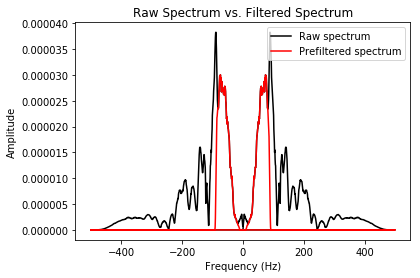

In [53]:
trace.data *= 0.00016985 # calibration factor
# move to frequency domain (FFT)
trace.detrend('constant') # remove the mean
trace.taper(max_percentage=0.02,type='cosine')

fft_trace = fft(trace.data, n=nfft)

# Plot the raw spectrum
plt.plot(freqs,np.abs(fft_trace),color="black")
fft_trace *= freq_taper
# Plot the prefiltered spectrum
plt.plot(freqs,np.abs(fft_trace),color="red")
plt.title('Raw Spectrum vs. Filtered Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(["Raw spectrum", "Prefiltered spectrum"])

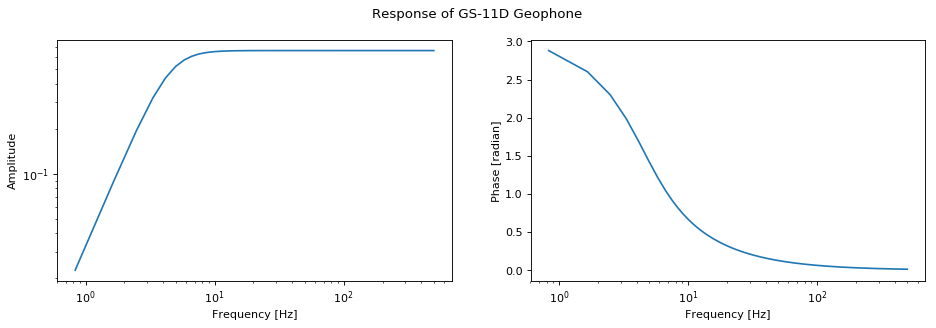

In [41]:
# Instrument response
import numpy as np
from obspy.signal.invsim import paz_to_freq_resp

poles = [-19.79 + 20.190j, -19.79 - 20.190j]
zeros = [0.0 + 0.0j, 0.0 + 0.0j]
scale_fac = .666

h, f = paz_to_freq_resp(poles, zeros, scale_fac, 0.001, len(fft_trace), freq=True)
fig=plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.loglog(f, np.abs(h))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.subplot(122)
plt.semilogx(f, np.angle(h))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [radian]')
plt.suptitle('Response of GS-11D Geophone')
plt.show()

In [58]:
# Remove Instrument Response and integrate to displacement
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html
# for Fourier convention
w = (2*np.pi*freqs[1:])                      # Omega
iw = (0+1j)*w                            # i*Omega
iw = iw/(iw+np.finfo(np.float).eps)**2   # Stable division
fft_trace[1:602] /= np.abs(h[1:602])*np.exp(1j*2*np.pi*np.angle(h[1:602]-np.pi))
fft_trace[1203:602:-1] /= np.abs(h[1:602])*np.exp(1j*2*np.pi*np.angle(h[1:602]-np.pi))
fft_trace[1:] *= iw

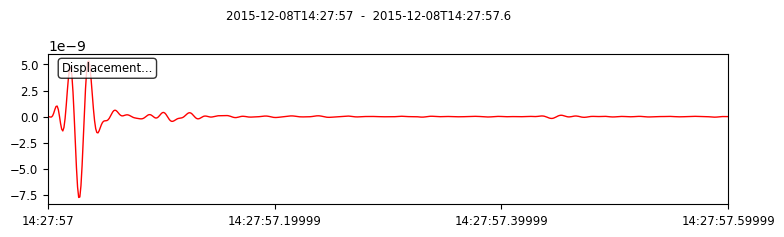

In [59]:
from obspy.core import Trace
disp = ifft(fft_trace)[0:npts] # displacement trace
displacement = Trace(data=disp)
displacement.stats.delta=0.001
displacement.stats.starttime = stime
displacement.stats.network = 'Displacement'
displacement.detrend('constant') # remove the mean
displacement.taper(max_percentage=0.02,type='cosine') # apply a cosine taper
displacement.plot(color="red")

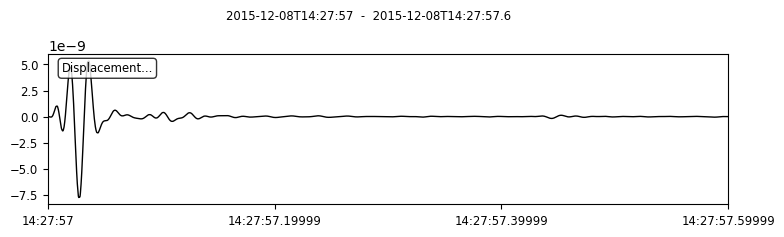

In [60]:
# Interpolate trace to simulation sampling rate
displacement.interpolate(sampling_rate=3333.3333)
len(displacement.data)
displacement.data = np.append(displacement.data,0.0) # Trace length set to 2001 for SPECFEM3D
displacement.plot()

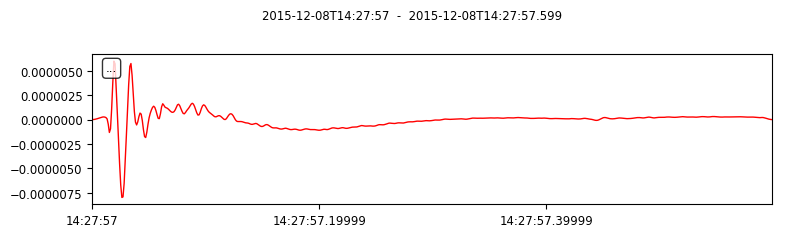

In [62]:
from scipy import integrate
mytrace = integrate.cumtrapz(trace.data)
t = Trace(data=mytrace)
t.stats.delta=0.001
t.stats.starttime = stime
displacement.stats.update()
t.detrend('constant') # remove the mean
t.taper(max_percentage=0.02,type='cosine') # apply a cosine taper
t.plot(color="red")